# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to <strong>identify segments of the population that form the core customer base </strong> for a mail-order sales company in Germany. <b>These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns.</b> The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

<b>Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties.</b> Then, you will see how the people in the customers dataset fit into those created clusters.<b>The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase.</b> This information can then be used for further applications, such as <b>targeting for a marketing campaign.</b>

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data. add sep argument as the file is separated with ";"
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file. add sep argument as the file is separated with ";"
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('demoraphics data: {}'.format(azdias.shape))
print('feature summary data: {}'.format(feat_info.shape))

demoraphics data: (891221, 85)
feature summary data: (85, 4)


There are 891221 observations and 85 variables for the demographics data.

In [4]:
# check the first 5 observations
# https://stackoverflow.com/questions/47022070/display-all-dataframe-columns-in-a-jupyter-python-notebook

# show all the columns
pd.options.display.max_columns = None

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


CAMEO_DEU_2015, OST_WEST_KZ need to be recorded later as they are not figure.

In [5]:
# check any missing data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

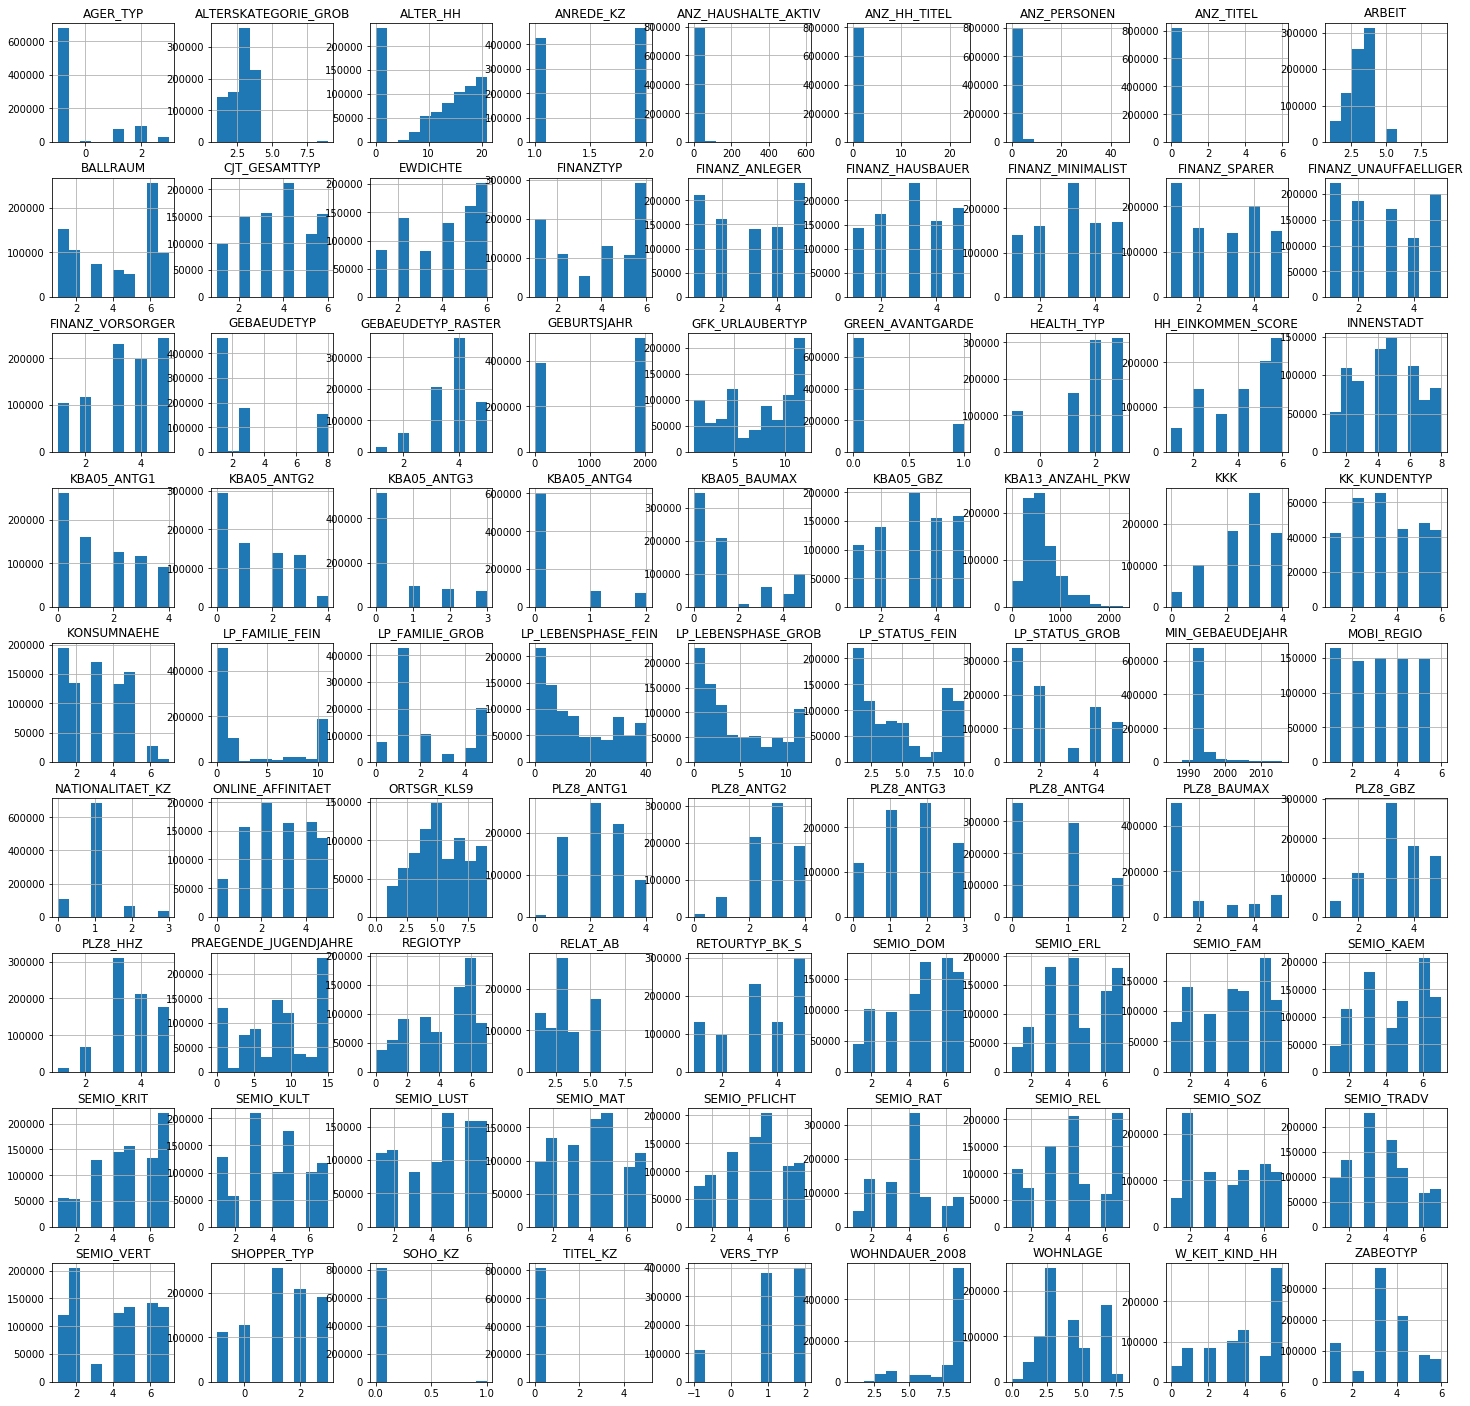

In [6]:
# quick check histogram
azdias.hist(figsize=(25,25));

> There seem to be binary data and categorical data.

In [7]:
# summary statistics
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [8]:
# check the summary data
feat_info.head(50)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> Looking at the feature summary, data type and missing value need to be handled.

## Data cleaning
- data type need to be matched with the type column in the feature summary data
- missing value
- CAMEO_DEU_2015, OST_WEST_KZ need to be recorded as they are not figure.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# convert string list to list
# https://stackoverflow.com/questions/45758646/pandas-convert-string-into-list-of-strings
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[]').split(','))

In [10]:
# create copy data drame
clean_azdias = azdias.copy()

In [11]:
# generate a dictionary for missing values
# https://stackoverflow.com/questions/17426292/what-is-the-most-efficient-way-to-create-a-dictionary-of-two-pandas-dataframe-co
miss_list = pd.Series(feat_info.missing_or_unknown.values, index = feat_info.attribute).to_dict()

In [12]:
# change str to float if it is available
for col in clean_azdias.columns:
    for i in range(len(miss_list[col])):
        try:
            miss_list[col][i] = float(miss_list[col][i])
        except:
            miss_list[col][i] = miss_list[col][i]
        else:
            miss_list[col][i] = float(miss_list[col][i])

In [13]:
# convert missing labels to NaN
for col in clean_azdias.columns:
    clean_azdias[col] = clean_azdias[col].map(lambda x: np.nan if x in miss_list[col] else x)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# get missing data
miss_var = clean_azdias.isna().sum()
miss_var.sort_values(ascending = False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

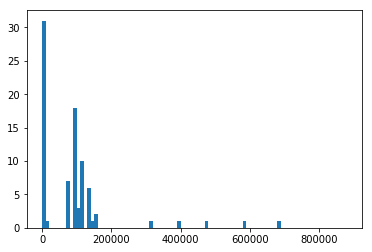

In [15]:
# investigate patterns in the amount of missing data in each column.
bins_edge = np.arange(0, miss_var.max() + 1, 10000)
plt.hist(miss_var, bins = bins_edge);

In [16]:
# get nan counts in descending order
miss_var.sort_values(ascending = False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

> As you can see in the above histogram, there are variables which are outstanding with the number of missing vaulue.

In [17]:
# get index(column number) of variables with more than 200000 missing values
# https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list

idx = [i for i, x in enumerate(miss_var > 200000) if x]

# get col name for dropping
drop_col = clean_azdias.iloc[:, idx].columns

print('There are {} outliers'.format(len(drop_col)))

There are 6 outliers


In [18]:
# get names of outlier columns
drop_col

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

>Personal information tend to have higher missing value. It may be that people are more sensible to the topic.

In [19]:
# remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

clean_azdias.drop(columns = drop_col, axis = 1, inplace = True)

In [20]:
# check
clean_azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

>While Finanz_ and Semio_ variables tend to receive full data, age related variables such as 'Ager_TYP', 'GEBURTSJAHR' and 'ALTER_HH' have lots of missing data. 

>Following 6 columns are removed from the dataset as there are outstanding missing values in the data:
'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

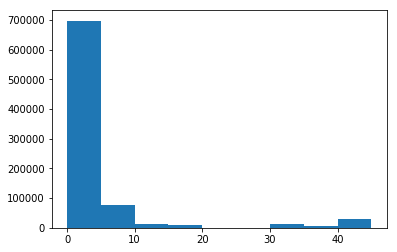

In [21]:
# how much data is missing in each row of the dataset?
sum_row_miss = clean_azdias.isna().sum(axis = 1)
bins_edge = np.arange(0, sum_row_miss.max() + 1, 5)
plt.hist(sum_row_miss, bins = bins_edge);

In [22]:
# get index for observations which miss more than 10 variables
row_idx = [i for i, x in enumerate(sum_row_miss > 10) if x]

miss_obs = clean_azdias.iloc[row_idx, :]
print('{:.1f}% of dataset contain more than 10 missing value.'.format(miss_obs.shape[0]/clean_azdias.shape[0]*100))

12.5% of dataset contain more than 10 missing value.


In [23]:
# get index for observations with missing value
row_idx = [i for i, x in enumerate(sum_row_miss > 0) if x]

miss_obs = clean_azdias.iloc[row_idx, :]
print('{:.1f}% of dataset contain at least 1 missing value.'.format(miss_obs.shape[0]/clean_azdias.shape[0]*100))

30.1% of dataset contain at least 1 missing value.


>As there is still enough data, I will drop observations which have more than 10 missing values.

In [24]:
def split_dataset(df, col_name, threshold):
    '''
    This function split the dataset based on the number of missing value
    and returns 2 charts.
    '''
    
    # get low missing val dataset
    less_idx = [i for i, x in enumerate(df.isna().sum(axis = 1) <= threshold) if x]
    
    # get high missing val dataset
    high_idx = [i for i, x in enumerate(df.isna().sum(axis = 1) > threshold) if x]
    
    # set color
    base_color = sns.color_palette()[0]

    # left chart
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2 ,1)
    sns.countplot(data = df, x = df.loc[less_idx, col_name], color = base_color)
    plt.title('dataset with low missing value')

    # right chart
    plt.subplot(1, 2 ,2)
    sns.countplot(data = df, x = df.loc[high_idx, col_name], color = base_color);
    plt.title('dataset with high missing value')

In [25]:
# get col name which has no missing value
col_name = clean_azdias.isna().sum().sort_values(ascending = True).index

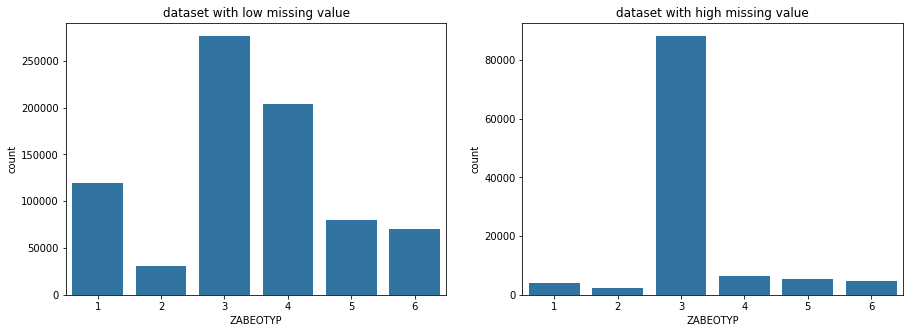

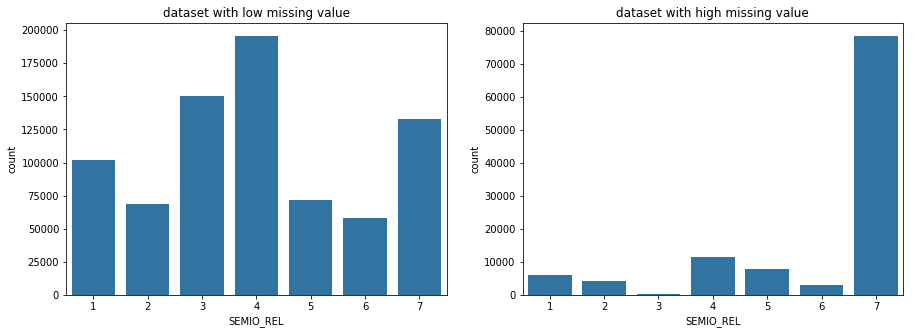

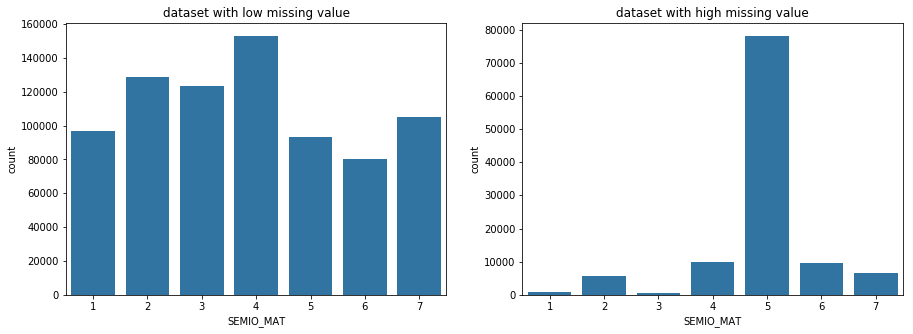

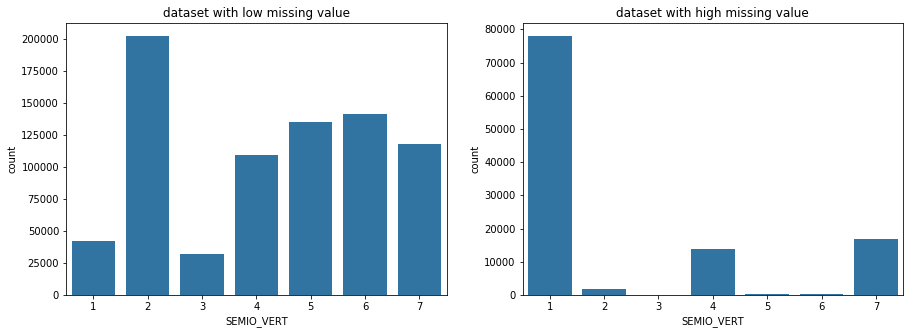

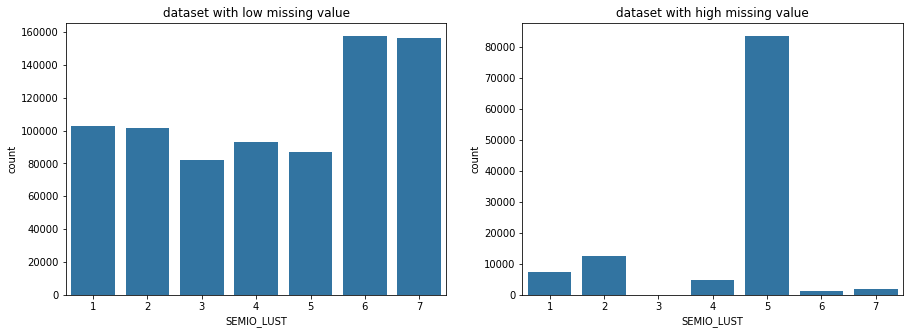

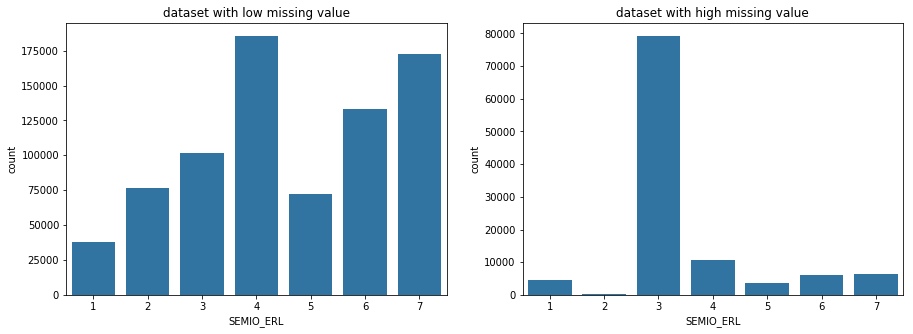

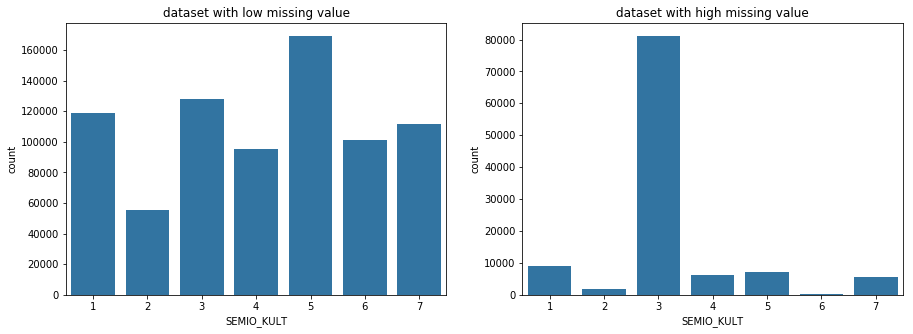

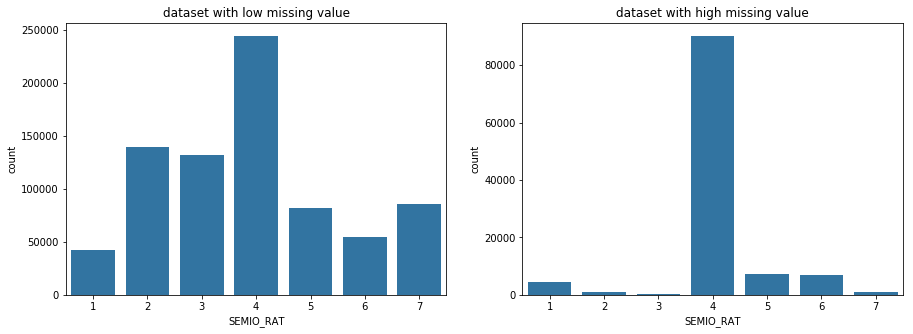

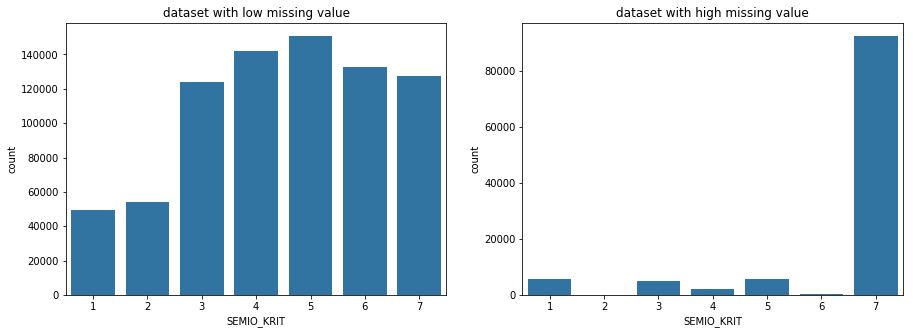

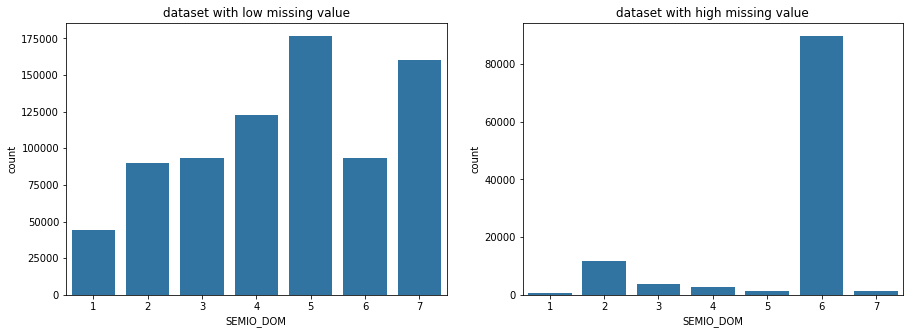

In [26]:
# show 10 charts and compare between data set with less missing value and the one with high missing value
for i in col_name[:10]:
    split_dataset(clean_azdias, i, 10)

In [27]:
# create a new dataset with less missing value
less_idx = [i for i, x in enumerate(sum_row_miss <= 10) if x]
new_azdias = clean_azdias.loc[less_idx,]

In [28]:
# ratio of dataset with less missing value
new_azdias.shape[0] / azdias.shape[0]

0.8753754680376696

#### Discussion 1.1.3: Assess Missing Data in Each Row
>There is a tendency that the observations who have more than 10 missing value share similar characteristics. Observations with less than 10 missing value have various characteristics.
Of course, I have to note that the amount of observation is different between them.
When I drop observations with more than 10 missing values value will reduce the dataset to about 87%. There is still enough amount of data. The next step is to recode the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# create a new df to compare data types
pd.options.display.max_rows = None
typ_check = pd.DataFrame(data = pd.Series(new_azdias.dtypes, index = feat_info.attribute), columns = ['typ'])
typ_check = typ_check.join(feat_info.set_index('attribute'), on='attribute')
# reset index
typ_check.reset_index(inplace = True)
# get index with na
drop_idx = list(typ_check.loc[typ_check.typ.isna(),].index)
# drop
typ_check.drop(typ_check.index[drop_idx], inplace = True)
# get var name with categorical variables
cat_col = typ_check.loc[typ_check.type == 'categorical',].attribute.values

cat_col

array(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [30]:
# check number of categorical variables
print(len(cat_col))

18


In [31]:
# check binary
binary_check = {}
# check feature numbers for creating dummy variables
dummy_col = {}
# to save binary column name for later
binary_col = []
# add to dictionary if unique value = 2
for col in cat_col:
    if new_azdias[col].nunique() == 2:
        binary_check[col] = new_azdias[col].unique()
        binary_col.append(col)
    else:
        dummy_col[col] = new_azdias[col].nunique()

binary_check

{'ANREDE_KZ': array([2, 1]),
 'GREEN_AVANTGARDE': array([0, 1]),
 'SOHO_KZ': array([ 1.,  0.]),
 'VERS_TYP': array([  2.,   1.,  nan]),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object)}

In [32]:
print('binary_column')
print(binary_col)
print('dummy columns')
print(dummy_col)

binary_column
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
dummy columns
{'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'ZABEOTYP': 6, 'GEBAEUDETYP': 7, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}


>'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP' and 'OST_WEST_KZ' are binary categorical variables. Therefore, I do not need to create dummy variable for them. However, 'OST_WEST_KZ' has to be recoded into numerical value.

In [33]:
# recode
new_azdias['OST_WEST_KZ'] = new_azdias['OST_WEST_KZ'].map({'O':0,'W':1})

In [34]:
# check results
new_azdias['OST_WEST_KZ'].unique()

array([1, 0])

In [35]:
# check dataset
new_azdias[cat_col].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,1,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,1,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,1,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,1,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,1,8,8C


>Now I would like to check if I can drop any categorical columns. Making dummy variables would generates huge amount of features which could slow down analysis. Moreover, as I will implement PCA later, categorical variables may be less informative.
https://stackoverflow.com/questions/40795141/pca-for-categorical-features

{'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'ZABEOTYP': 6, 'GEBAEUDETYP': 7, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}

- 'CJT_GESAMTTYP'
:Customer-Journey-Typology: preferred information and buying channels for consumer

- 'FINANZTYP': Most descriptive financial type for individual

- 'GFK_URLAUBERTYP': Vacation habits
- 'LP_FAMILIE_FEIN': Family type, fine scale
- 'LP_FAMILIE_GROB': Life stage, rough scale
- 'LP_STATUS_FEIN': Social status, fine scale
- 'LP_STATUS_GROB': Social status, rough scale
- 'NATIONALITAET_KZ': Nationality based on given name analysis
- 'SHOPPER_TYP': Shopper typology
- 'ZABEOTYP': Energy consumption typology
- 'GEBAEUDETYP': Type of building (residential vs. commercial)
- 'CAMEO_DEUG_2015': German CAMEO: Wealth / Life Stage Typology, rough scale
- 'CAMEO_DEU_2015': German CAMEO: Wealth / Life Stage Typology, detailed scale

In [36]:
# get number of missing value
for i in dummy_col:
    print(i, miss_var[i])

CJT_GESAMTTYP 4854
FINANZTYP 0
GFK_URLAUBERTYP 4854
LP_FAMILIE_FEIN 77792
LP_FAMILIE_GROB 77792
LP_STATUS_FEIN 4854
LP_STATUS_GROB 4854
NATIONALITAET_KZ 108315
SHOPPER_TYP 111196
ZABEOTYP 0
GEBAEUDETYP 93148
CAMEO_DEUG_2015 99352
CAMEO_DEU_2015 99352


> There are variables which convey similar characteristics. I will choose the rough version and drop the fine version.<p>
'CAMEO_DEUG_2015' and 'CAMEO_DEU_2015' --> 'CAMEO_DEUG_2015' <p>
'LP_FAMILIE_FEIN' and 'LP_FAMILIE_GROB' --> 'LP_FAMILIE_GROB' <P>
'LP_STATUS_FEIN' and 'LP_STATUS_GROB' --> 'LP_STATUS_GROB' <p>
> Further more, I will remove 'ZABEOTYP' and 'FINANZTYP' as there are already similar variables like 'GREEN_AVANTGARDE' and FINANZTYP...

In [37]:
# drop the columns
drop_cat = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'ZABEOTYP', 'FINANZTYP']
new_azdias = new_azdias.drop(columns = drop_cat, axis = 1)

In [38]:
# update dummy_col
for i in drop_cat:
    del dummy_col[i]
dummy_col

{'CJT_GESAMTTYP': 6,
 'GFK_URLAUBERTYP': 12,
 'LP_FAMILIE_GROB': 5,
 'LP_STATUS_GROB': 5,
 'NATIONALITAET_KZ': 3,
 'SHOPPER_TYP': 4,
 'GEBAEUDETYP': 7,
 'CAMEO_DEUG_2015': 9}

> I will now fill in missing value for categorical variables.

In [39]:
# update feature_info too
pd.options.display.max_rows = None
typ_check = pd.DataFrame(data = pd.Series(new_azdias.dtypes, index = feat_info.attribute), columns = ['typ'])
typ_check = typ_check.join(feat_info.set_index('attribute'), on='attribute')
# reset index
typ_check.reset_index(inplace = True)
# get index with na
drop_idx = list(typ_check.loc[typ_check.typ.isna(),].index)
# drop
typ_check.drop(typ_check.index[drop_idx], inplace = True)
# get var name with categorical variables
cat_col = typ_check.loc[typ_check.type == 'categorical',].attribute.values

cat_col

array(['ANREDE_KZ', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015'], dtype=object)

In [40]:
# filling in categorical missing value
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
new_azdias.loc[:, cat_col] = imp.fit_transform(new_azdias.loc[:, cat_col])

In [41]:
# check
new_azdias[cat_col].isna().sum()

ANREDE_KZ           0
CJT_GESAMTTYP       0
GFK_URLAUBERTYP     0
GREEN_AVANTGARDE    0
LP_FAMILIE_GROB     0
LP_STATUS_GROB      0
NATIONALITAET_KZ    0
SHOPPER_TYP         0
SOHO_KZ             0
VERS_TYP            0
GEBAEUDETYP         0
OST_WEST_KZ         0
CAMEO_DEUG_2015     0
dtype: int64

In [42]:
# align data types
new_azdias.loc[:, cat_col] = new_azdias.loc[:, cat_col].astype('category')

# Re-encode categorical variable(s) to be kept in the analysis.

In [43]:
# https://www.ritchieng.com/machinelearning-one-hot-encoding/
# select only categorical var
X = new_azdias.select_dtypes(include = ['category'])
# drop binary variables
X = X.drop(columns = binary_col, axis = 1)

# drop non binary catagorical variables to merge with the dummy variables later
non_cat_df = new_azdias.drop(columns = X, axis = 1)

> OneHotEncoder from sklearn does not return columns names after transforming. Therefore, I will use get_dummies from pandas.

In [45]:
# create dummy variables
dummy = pd.get_dummies(X)

In [47]:
# merge the original dataset with the dummy variables
# https://stackoverflow.com/questions/50414823/how-to-keep-columns-names-after-one-hot-encoding-sklearn
dummy_azdias = non_cat_df.join(pd.DataFrame(data = dummy, index = non_cat_df.index))
dummy_azdias.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
1,1.0,2.0,1,5,2,5,4,5,0.0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,3.0,2.0,1,4,1,2,3,5,1.0,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4.0,2.0,4,2,5,2,1,2,0.0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3.0,1.0,4,3,4,1,3,2,0.0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1.0,2.0,3,1,5,2,2,5,0.0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,2.0,2.0,1,5,1,5,4,3,0.0,2.0,2.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,1.0,5.0,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,1.0,1.0,3,3,4,1,3,2,0.0,1.0,5.0,2.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,1.0,1.0,0.0,4.0,5.0,9.0,6.0,0.0,3.0,1992.0,1.0,1.0,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.

In [48]:
# check the dataset
dummy_azdias.shape

(780153, 117)

#### Discussion 1.2.1: Re-Encode Categorical Features

>I used the feature_info data to find out 18 categorical variables.
'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP' and 'OST_WEST_KZ' are binary variables.
As 'OST_WEST_KZ' contains string data, I transformed it into integer data.

>Other 13 categorical variables were handeled either by dropping them or recoded into dummy variables.
'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'ZABEOTYP', 'FINANZTYP' were dropeed as there are other variables which deliver the similar characteristics.

>'ANREDE_KZ', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'GEBAEUDETYP', 'OST_WEST_KZ' and 'CAMEO_DEUG_2015' were cleaned and then recoded into dummy variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, **you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.**
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

###### "PRAEGENDE_JUGENDJAHRE": 
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [49]:
# prepare references
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgrade = [2, 4, 6, 7, 9, 11, 13, 15]
jugendjahr_dict = {1:1940, 2:1940, 3:1950, 4:1950, 5:1960, 6:1960, 7:1960, 8:1970, 9:1970,
                   10:1980, 11:1980, 12:1980, 13:1980, 14:1990, 15:1990}

In [50]:
# create new columns based on the original
# https://stackoverflow.com/questions/44991438/lambda-including-if-elif-else
dummy_azdias["JUGEND_MOVEMENT"] = dummy_azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in mainstream else (0 if x in avantgrade else np.nan))
dummy_azdias["JUGENDJAHRE"] = dummy_azdias["PRAEGENDE_JUGENDJAHRE"].map(jugendjahr_dict)

In [51]:
# check
dummy_azdias[["JUGEND_MOVEMENT", "PRAEGENDE_JUGENDJAHRE", "JUGENDJAHRE"]].sample(10)

,JUGEND_MOVEMENT,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE
541368,1.0,3.0,1950.0
613106,0.0,6.0,1960.0
66273,NaN,NaN,NaN
448395,1.0,14.0,1990.0
205377,1.0,8.0,1970.0
99888,1.0,10.0,1980.0
842538,0.0,9.0,1970.0
482363,1.0,10.0,1980.0
878191,1.0,10.0,1980.0
60077,1.0,8.0,1970.0


In [52]:
# drop the original column
dummy_azdias = dummy_azdias.drop(columns = "PRAEGENDE_JUGENDJAHRE", axis = 1)

> I will fill in the missing numerical variables with mean.

In [53]:
# filling in missing value with mean
imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis=0)
dummy_azdias["JUGENDJAHRE"] = imp.fit_transform(dummy_azdias[["JUGENDJAHRE"]])

In [54]:
# filling in missing value 
cat_imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)
dummy_azdias["JUGEND_MOVEMENT"] = cat_imp.fit_transform(dummy_azdias[["JUGEND_MOVEMENT"]])
dummy_azdias["JUGEND_MOVEMENT"] = dummy_azdias["JUGEND_MOVEMENT"].astype('category')

In [55]:
# check
dummy_azdias[["JUGEND_MOVEMENT", "JUGENDJAHRE"]].isna().sum()

JUGEND_MOVEMENT    0
JUGENDJAHRE        0
dtype: int64

###### German CAMEO: Wealth / Life Stage Typology, mapped to international code
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

> I will create wealth column and life_stage column.

In [56]:
# separate 1st digit and 10th digit
dummy_azdias['WEALTH'] = dummy_azdias.CAMEO_INTL_2015.str[0]
dummy_azdias['LIFE_STAGE'] = dummy_azdias.CAMEO_INTL_2015.str[1]

In [57]:
# check
(dummy_azdias['WEALTH'] + dummy_azdias['LIFE_STAGE']).head()

1    51
2    24
3    12
4    43
5    54
dtype: object

In [58]:
# check
dummy_azdias.CAMEO_INTL_2015.head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [59]:
# drop the original column
dummy_azdias = dummy_azdias.drop(columns = "CAMEO_INTL_2015", axis = 1)

In [60]:
# convert string to int
dummy_azdias['WEALTH'] = dummy_azdias['WEALTH'].apply(lambda x: float(x) if type(x) == str else np.nan)
dummy_azdias['LIFE_STAGE'] = dummy_azdias['LIFE_STAGE'].apply(lambda x: float(x) if type(x) == str else np.nan)

In [61]:
# filling in missing value with mean
imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis=0)
dummy_azdias['WEALTH'] = imp.fit_transform(dummy_azdias[['WEALTH']])
dummy_azdias['LIFE_STAGE'] = imp.fit_transform(dummy_azdias[['LIFE_STAGE']])

In [62]:
# check 
dummy_azdias[['WEALTH','LIFE_STAGE']].isna().sum()

WEALTH        0
LIFE_STAGE    0
dtype: int64

In [63]:
# update feature_info
pd.options.display.max_rows = None
typ_check = pd.DataFrame(data = pd.Series(dummy_azdias.dtypes, index = feat_info.attribute), columns = ['typ'])
typ_check = typ_check.join(feat_info.set_index('attribute'), on='attribute')
# reset index
typ_check.reset_index(inplace = True)
# get index with na
drop_idx = list(typ_check.loc[typ_check.typ.isna(),].index)
# drop
typ_check.drop(typ_check.index[drop_idx], inplace = True)
# get var name with mixed type
cat_col = typ_check.loc[typ_check.type == 'mixed',].attribute.values

cat_col

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE',
       'PLZ8_BAUMAX'], dtype=object)

> While 'WOHNLAGE' delivers interesting features like, how good or how poor the neigborfood is, other 3 are already covered in other variables. Therefore, I will drop 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB' and 'PLZ8_BAUMAX'.

In [64]:
# drop some mixed columns
dummy_azdias = dummy_azdias.drop(columns = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

> "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" are separated into two columns. The reason being that one column convey several meanings. "PRAEGENDE_JUGENDJAHRE" are splited into "JUGEND_MOVEMENT" and "JUGENDJAHRE". The former shows either if an observation is mainstream or avantgarde. "CAMEO_INTL_2015" are splited into 'WEALTH' and 'LIFE_STAGE'. The former conveys the wealth status of observations and the latter is about their life stage, for example, if they are young or old. Then, original columns are droped.
> Other mixed type 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB' and 'PLZ8_BAUMAX' are also droped as they deliver similar charactersitics from other variables.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# update feature_info too
pd.options.display.max_rows = None
typ_check = pd.DataFrame(data = pd.Series(dummy_azdias.dtypes, index = feat_info.attribute), columns = ['typ'])
typ_check = typ_check.join(feat_info.set_index('attribute'), on='attribute')
# reset index
typ_check.reset_index(inplace = True)
# get index with na
drop_idx = list(typ_check.loc[typ_check.typ.isna(),].index)
# drop
typ_check.drop(typ_check.index[drop_idx], inplace = True)
typ_check

,attribute,typ,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,float64,person,ordinal,"[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,category,person,categorical,"[-1.0, 0.0]"
4,FINANZ_MINIMALIST,int64,person,ordinal,[-1.0]
5,FINANZ_SPARER,int64,person,ordinal,[-1.0]
6,FINANZ_VORSORGER,int64,person,ordinal,[-1.0]
7,FINANZ_ANLEGER,int64,person,ordinal,[-1.0]
8,FINANZ_UNAUFFAELLIGER,int64,person,ordinal,[-1.0]
9,FINANZ_HAUSBAUER,int64,person,ordinal,[-1.0]
13,GREEN_AVANTGARDE,category,person,categorical,[]
14,HEALTH_TYP,float64,person,ordinal,"[-1.0, 0.0]"


In [66]:
# check missing value
numeric_col = dummy_azdias.loc[:, dummy_azdias.isna().sum() > 0].columns

In [67]:
# filling in missing value for numerical variables
imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
dummy_azdias.loc[:, numeric_col] = imp.fit_transform(dummy_azdias.loc[:, numeric_col])

In [68]:
# check
dummy_azdias.isna().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0
ANZ_HAUSHALTE_AKTIV      0
ANZ_HH_TITEL             0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
W

In [69]:
# check cleaned df shape
dummy_azdias.shape

(780153, 116)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [70]:
# load customer data to test
cust_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
cust_df.shape

(191652, 85)

In [71]:
# check first 10 rows
cust_df.sample(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
161014,3,2,1,5.0,3,1,5,1,2,4,5,0,2.0,0,3,2.0,1.0,1.0,1.0,1.0,1.0,2,1,5.0,7,7,6,3,7,2,1,7,4,5,4,4,6,5,1,0.0,0.0,2,6,6.0,1.0,0.0,5.0,NaN,6.0,9.0,25.0,1.0,8.0,1.0,1991.0,W,4.0,9,9D,51,0.0,0.0,0.0,1.0,0.0,1.0,6.0,6.0,2.0,3.0,3.0,1.0,3.0,7.0,475.0,1.0,4.0,3.0,2.0,4.0,5.0,3.0,4.0,7.0,4.0
96378,-1,4,1,5.0,5,2,4,4,2,1,6,0,1.0,0,2,38.0,12.0,11.0,5.0,9.0,4.0,1,10,3.0,4,4,3,6,6,7,7,4,3,1,3,3,2,2,2,0.0,0.0,1,1,16.0,3.0,0.0,5.0,4.0,1.0,9.0,2.0,0.0,8.0,6.0,1992.0,W,7.0,3,3C,24,3.0,1.0,0.0,0.0,1.0,5.0,6.0,1.0,6.0,5.0,4.0,5.0,5.0,7.0,502.0,3.0,1.0,0.0,0.0,1.0,3.0,4.0,2.0,3.0,2.0
107082,-1,3,1,1.0,5,2,4,1,2,1,6,1965,8.0,1,1,28.0,8.0,8.0,4.0,10.0,5.0,1,11,5.0,6,4,4,6,5,6,4,5,5,3,5,3,3,4,1,0.0,0.0,2,1,21.0,3.0,0.0,3.0,NaN,1.0,9.0,2.0,0.0,1.0,5.0,1992.0,W,2.0,2,2D,14,3.0,1.0,0.0,0.0,1.0,4.0,2.0,5.0,3.0,4.0,2.0,5.0,3.0,7.0,535.0,3.0,3.0,1.0,0.0,1.0,3.0,4.0,4.0,7.0,5.0
178456,2,4,1,1.0,5,1,5,2,1,2,6,1923,3.0,0,1,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,4,4,4,4,7,4,4,4,1,3,1,4,4,4,3,0.0,0.0,1,1,6.0,0.0,0.0,1.0,3.0,NaN,9.0,1.0,0.0,8.0,5.0,1994.0,W,7.0,2,2C,14,2.0,1.0,0.0,0.0,0.0,5.0,6.0,2.0,8.0,5.0,0.0,4.0,4.0,0.0,1700.0,3.0,2.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,2.0
89078,-1,2,2,4.0,5,2,3,5,2,2,6,1971,3.0,0,2,34.0,11.0,10.0,5.0,9.0,4.0,1,12,2.0,1,2,7,7,1,3,5,6,7,4,4,5,6,7,2,0.0,0.0,1,2,0.0,2.0,0.0,3.0,2.0,3.0,9.0,1.0,0.0,1.0,4.0,1994.0,O,7.0,3,3C,24,4.0,1.0,0.0,0.0,1.0,3.0,7.0,2.0,7.0,5.0,3.0,4.0,5.0,5.0,616.0,3.0,2.0,0.0,0.0,1.0,3.0,4.0,3.0,2.0,1.0
98714,-1,3,2,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13639,-1,4,1,3.0,5,2,4,2,4,1,3,1965,2.0,1,1,28.0,8.0,7.0,4.0,10.0,5.0,1,11,3.0,3,6,5,6,7,7,3,6,3,3,3,1,4,1,2,0.0,0.0,1,2,15.0,2.0,0.0,2.0,3.0,1.0,9.0,1.0,0.0,1.0,4.0,2000.0,W,8.0,5,5B,32,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,6.0,4.0,2.0,4.0,3.0,2.0,482.0,3.0,3.0,1.0,0.0,1.0,3.0,3.0,2.0,3.0,2.0
67031,-1,1,2,6.0,3,4,3,5,5,3,4,0,5.0,0,-1,0.0,0.0,0.0,0.0,5.0,2.0,0,0,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28851,1,4,1,1.0,5,1,5,1,2,2,5,1945,10.0,0,1,19.0,5.0,2.0,2.0,9.0,4.0,1,5,5.0,4,2,5,6,6,7,3,6,3,3,3,1,2,1,0,0.0,0.0,1,1,11.0,2.0,0.0,2.0,4.0,6.0,9.0,1.0,0.0,1.0,2.0,1992.0,W,1.0,2,2D,14,4.0,1.0,0.0,0.0,1.0,5.0,3.0,4.0,5.0,4.0,1.0,5.0,4.0,1.0,1068.0,2.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,5.0,2.0
33811,-1,3,1,3.0,5,2,4,2,1,1,6,1963,4.0,1,1,39.0,12.0,10.0,5.0,10.0,5.0,1,9,3.0,3,5,4,6,7,1,4,5,5,3,5,3,3,4,1,0.0,0.0,2,1,0.0,3.0,0.0,1.0,NaN,3.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,2,2A,12,3.0,1.0,0.0,0.0,1.0,5.0,5.0,4.0,8.0,5.0,2.0,4.0,2.0,2.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,1.0


In [72]:
# this function will be used later
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # create a dictionary to align na values
    miss_list = {'AGER_TYP': [-1, 0], 'ALTERSKATEGORIE_GROB': [-1, 0, 9], 'ANREDE_KZ': [-1, 0],
    'CJT_GESAMTTYP': [0], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_VORSORGER': [-1],
    'FINANZ_ANLEGER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZTYP': [-1],
    'GEBURTSJAHR': [0], 'GFK_URLAUBERTYP': [''], 'GREEN_AVANTGARDE': [''], 'HEALTH_TYP': [-1, 0],
    'LP_LEBENSPHASE_FEIN': [0], 'LP_LEBENSPHASE_GROB': [0], 'LP_FAMILIE_FEIN': [0], 'LP_FAMILIE_GROB': [0],
    'LP_STATUS_FEIN': [0], 'LP_STATUS_GROB': [0], 'NATIONALITAET_KZ': [-1, 0], 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
    'RETOURTYP_BK_S': [0], 'SEMIO_SOZ': [-1, 9], 'SEMIO_FAM': [-1, 9], 'SEMIO_REL': [-1, 9], 'SEMIO_MAT': [-1, 9],
    'SEMIO_VERT': [-1, 9], 'SEMIO_LUST': [-1, 9], 'SEMIO_ERL': [-1, 9], 'SEMIO_KULT': [-1, 9], 'SEMIO_RAT': [-1, 9],
    'SEMIO_KRIT': [-1, 9], 'SEMIO_DOM': [-1, 9], 'SEMIO_KAEM': [-1, 9], 'SEMIO_PFLICHT': [-1, 9], 'SEMIO_TRADV': [-1, 9],
    'SHOPPER_TYP': [-1], 'SOHO_KZ': [-1], 'TITEL_KZ': [-1, 0], 'VERS_TYP': [-1], 'ZABEOTYP': [-1, 9], 'ALTER_HH': [0],
    'ANZ_PERSONEN': [''], 'ANZ_TITEL': [''], 'HH_EINKOMMEN_SCORE': [-1, 0], 'KK_KUNDENTYP': [-1], 'W_KEIT_KIND_HH': [-1, 0],
    'WOHNDAUER_2008': [-1, 0], 'ANZ_HAUSHALTE_AKTIV': [0], 'ANZ_HH_TITEL': [''], 'GEBAEUDETYP': [-1, 0], 'KONSUMNAEHE': [''],
    'MIN_GEBAEUDEJAHR': [0], 'OST_WEST_KZ': [-1], 'WOHNLAGE': [-1], 'CAMEO_DEUG_2015': [-1, 'X'], 'CAMEO_DEU_2015': ['XX'],
    'CAMEO_INTL_2015': [-1, 'XX'], 'KBA05_ANTG1': [-1], 'KBA05_ANTG2': [-1], 'KBA05_ANTG3': [-1], 'KBA05_ANTG4': [-1],
    'KBA05_BAUMAX': [-1, 0], 'KBA05_GBZ': [-1, 0], 'BALLRAUM': [-1], 'EWDICHTE': [-1], 'INNENSTADT': [-1],'GEBAEUDETYP_RASTER': [''],
    'KKK': [-1, 0], 'MOBI_REGIO': [''], 'ONLINE_AFFINITAET': [''], 'REGIOTYP': [-1, 0], 'KBA13_ANZAHL_PKW': [''], 'PLZ8_ANTG1': [-1],
    'PLZ8_ANTG2': [-1], 'PLZ8_ANTG3': [-1], 'PLZ8_ANTG4': [-1], 'PLZ8_BAUMAX': [-1, 0], 'PLZ8_HHZ': [-1], 'PLZ8_GBZ': [-1],
    'ARBEIT': [-1, 9], 'ORTSGR_KLS9': [-1, 0], 'RELAT_AB': [-1, 9]}
    
    cat_list = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
               'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
                'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    
    # convert missing or unknown value to nan
    for col in df.columns:
        df[col] = df[col].map(lambda x: np.nan if x in miss_list[col] else x)
    
    # recode ost_west
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O':0,'W':1})
    
    # define categorical variables
    df.loc[:, cat_list] = df.loc[:, cat_list].astype('category')
       
    # remove selected columns
    drop_col = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ',
                'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX',
                'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN',
                'ZABEOTYP', 'FINANZTYP','LP_LEBENSPHASE_FEIN',
                'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']
    
    df.drop(columns = drop_col, axis = 1, inplace = True)    
    cat_col = df.select_dtypes(include = ['category']).columns
    
    # get index for observations which miss more than 10 variables
    sum_row_miss = df.isna().sum(axis = 1)
    row_idx = [i for i, x in enumerate(sum_row_miss <= 10) if x]
    df = df.iloc[row_idx, :]
    
    # handle categorical missing value
    cat_imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
    df.loc[:, cat_col] = cat_imp.fit_transform(df.loc[:, cat_col])
    # re-update data type
    df.loc[:, cat_col] = df.loc[:, cat_col].astype('category')
    
    # select, re-encode, and engineer column values.
    binary_var = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
    X = df.select_dtypes(include = ['category'])
    
    # drop binary variable
    X = X.drop(columns = binary_var, axis = 1)
    # drop catagorical variables
    non_cat_df = df.drop(columns = X, axis = 1)
    # get new categoricla columns without binary var
    cat_col = X.columns
    
    # create dummy variables
    dummy = pd.get_dummies(X)
          
    # merge the dummy variables with the non categorical data set
    dummy_azdias = non_cat_df.join(pd.DataFrame(data = dummy, index = non_cat_df.index))
    
    # feature engineering /"PRAEGENDE_JUGENDJAHRE"
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgrade = [2, 4, 6, 7, 9, 11, 13, 15]
    jugendjahr_dict = {1:1949, 2:1940, 3:1950, 4:1950, 5:1960, 6:1960, 7:1960, 8:1970, 9:1970,
                       10:1980, 11:1980, 12:1980, 13:1980, 14:1990, 15:1990}
    dummy_azdias["JUGEND_MOVEMENT"] = dummy_azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in mainstream else (0 if x in avantgrade else np.nan))
    dummy_azdias["JUGEND_MOVEMENT"] = dummy_azdias["JUGEND_MOVEMENT"].astype('category')
    dummy_azdias["JUGENDJAHRE"] = dummy_azdias["PRAEGENDE_JUGENDJAHRE"].map(jugendjahr_dict)
    dummy_azdias = dummy_azdias.drop(columns = "PRAEGENDE_JUGENDJAHRE", axis = 1)
    
    # feature engineering CAMEO_INTL_2015
    dummy_azdias['WEALTH'] = dummy_azdias.CAMEO_INTL_2015.str[0]
    dummy_azdias['LIFE_STAGE'] = dummy_azdias.CAMEO_INTL_2015.str[1]
    dummy_azdias['WEALTH'] = dummy_azdias['WEALTH'].apply(lambda x: float(x) if type(x) == str else np.nan)
    dummy_azdias['LIFE_STAGE'] = dummy_azdias['LIFE_STAGE'].apply(lambda x: float(x) if type(x) == str else np.nan)
    
    # drop the original column
    dummy_azdias = dummy_azdias.drop(columns = "CAMEO_INTL_2015", axis = 1)
    
    # handle na values
    cat_col = dummy_azdias.select_dtypes(include = ['category']).columns
    numerical_col = dummy_azdias.select_dtypes(include = ['float']).columns
    cat_imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
    dummy_azdias.loc[:, cat_col] = cat_imp.fit_transform(dummy_azdias.loc[:, cat_col])
    imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
    dummy_azdias.loc[:, numerical_col] = imp.fit_transform(dummy_azdias.loc[:, numerical_col])
    
    # Return the cleaned dataframe.
    return dummy_azdias
    

In [73]:
# test
clean_cust_df = clean_data(cust_df)
clean_cust_df.head();

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
# check data shape
clean_cust_df.shape

(139578, 115)

> The two data sets have different number of columns due to dummy variables.

In [77]:
# get column name
demographic_col = dummy_azdias.columns
clean_cust_df_col = clean_cust_df.columns
# check which column is missing
miss_col = []
for i in demographic_col:
    if i not in clean_cust_df_col:
        miss_col.append(i)

miss_col

['GEBAEUDETYP_5.0']

> The customer data needs to have one additional column later.

In [78]:
# check if there is no missing value
clean_cust_df.isna().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0
ANZ_HAUSHALTE_AKTIV      0
ANZ_HH_TITEL             0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
W

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [79]:
# apply feature scaling to the general population demographics data.
scaler = StandardScaler()
dummy_azdias[dummy_azdias.columns] = scaler.fit_transform(dummy_azdias[dummy_azdias.columns])
new_azdias = dummy_azdias
new_azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,JUGEND_MOVEMENT,JUGENDJAHRE,WEALTH,LIFE_STAGE
count,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05
mean,-7.685107e-17,4.519714e-17,1.012780e-16,7.527544e-17,8.963834e-17,1.339657e-16,9.701560e-17,-1.161965e-16,-8.288040e-17,1.019065e-16,-3.121758e-15,-1.514616e-16,1.623909e-16,-7.172342e-18,2.644886e-17,1.320166e-16,-8.408262e-17,1.400770e-16,9.663763e-17,-9.326549e-17,-1.505509e-17,-3.005553e-19,-5.838059e-18,-1.821911e-16,-1.110597e-16,5.252431e-17,-3.154009e-17,3.621236e-17,-5.769751e-18,4.189558e-19,9.990002e-16,1.927561e-16,1.732473e-16,1.282369e-17,8.450248e-16,-3.796212e-14,-1.216793e-16,-1.439113e-16,1.617534e-17,4.446397e-17,-3.375623e-16,-1.258689e-17,-3.599013e-16,-1.171328e-15,-1.294920e-15,2.629950e-16,-7.820357e-17,5.958645e-16,6.322226e-16,6.015842e-16,-7.032994e-17,-4.810706e-17,3.460940e-18

### Discussion 2.1: Apply Feature Scaling

It is important to standardize all features before doing analysis based on distances. For example, if two features have different units, like "5kg and 5000gms", distance based analysis puts more weight on a feature with high magnitude. Standardization scales each feature to mean 0 and standard deviation 1. You can see the result in the above cell that mean and standard deviation are extremely closed to 0 and 1. The formula is as below.
$$x'=\frac{x - \bar x}{\sigma}$$


*reference https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

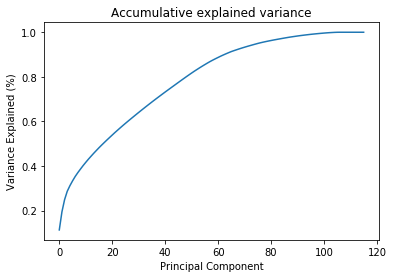

In [80]:
# apply PCA to the data without any parameter.
# initialize PCA
pca = PCA()
pca.fit(new_azdias)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Variance Explained (%)")
plt.xlabel("Principal Component")
plt.title('Accumulative explained variance');

> Around 80 components explain more than 90% of variance. I will use the scree_plot function from the lecture to see more in details.

In [81]:
# scree_plot function from the Udacity lecture with a little bit of adjustment

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.08, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    # focus on the first 10 components
    plt.xlim(-1, 10)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [82]:
# re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 80)
pca.fit(new_azdias)
pca.explained_variance_ratio_.sum()

0.96045636102586784

In [83]:
# print results
for i in range(10, 90, 10):
    result = pca.explained_variance_ratio_[:i].sum()
    print('{} components account for {:.1f} %.'.format(i, result *100))

10 components account for 40.2 %.
20 components account for 52.8 %.
30 components account for 63.0 %.
40 components account for 72.3 %.
50 components account for 80.9 %.
60 components account for 88.1 %.
70 components account for 92.9 %.
80 components account for 96.0 %.


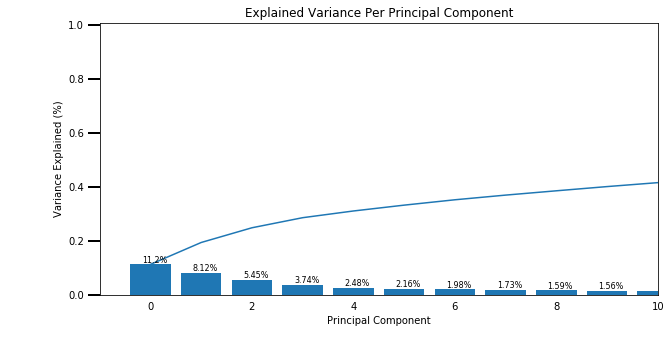

In [84]:
# plot components with the scree_plot function
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

> While I could reduce 116 features to 80 features with a 4% loss of information, the first 5 compoents account for more than 30% of variance. Each component explains over 1% until 30 components. And it declines around 40 components. Therfore I would reduce the features to 40 components. It is almost 75% feature reduction from the dataset before applying PCA and it still explains 72% of variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [85]:
# reduce features into 40
pca = PCA(n_components = 40)
pca = pca.fit(new_azdias)
pca_azdias = pca.transform(new_azdias)

In [86]:
# from udacity lecture
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    df = pd.concat([variance_ratios, components], axis = 1)
    # Return a concatenated DataFrame
    return df

In [87]:
# check first 3 components
pca_result = pca_results(new_azdias, pca)
pca_result.head(3)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,JUGEND_MOVEMENT,JUGENDJAHRE,WEALTH,LIFE_STAGE
Dimension 1,0.1129,-0.0929,0.0101,-0.1996,0.1215,-0.0908,0.0534,0.0553,0.1561,-0.1058,0.0273,-0.0079,0.0317,0.0615,0.0878,0.0632,-0.0400,-0.0567,-0.0560,0.0538,0.0748,0.0117,0.0248,0.0396,0.0914,0.0663,-0.0020,0.0317,-0.0829,-0.0043,0.1940,0.0428,-0.0559,0.1270,0.0311,-0.1534,-0.0564,-0.0469,-0.0756,-0.2087,0.0097,0.1242,0.1414,-0.2000,-0.1125,0.1759,-0.1465,-0.1093,0.0405,-0.2240,-0.0534,0.0666,-0.0691,-0.2042,0.1397,0.2045,0.1984,0.0393,-0.1500,0.1287,0.1778,0.1215,-0.0183,-0.0503,0.0197,0.0209,0.0086,0.0163,-0.0192,-0.0182,-0.0143,0.0148,-0.0290,-0.0313,-0.0438,0.0066,-0.0024,-0.0019,0.0277,0.0618,0.0866,-0.0296,0.0052,-0.0292,-0.0642,0.2063,-0.0196,-0.0269,-0.1204,-0.1166,-0.0619,0.0537,0.0283,-0.0215,0.0153,0.0368,-0.0373,-0.0991,-0.0179,0.0757,-0.0055,0.0004,-0.0035,0.0479,-0.0494,-0.0940,-0.0709,-0.0792,-0.0114,0.0019,0.0364,0.0968,0.1222,0.1058,0.0788,0.1979,-0.1180
Dimension 2,0.0812,0.2543,0.0788,0.0791,-0.2343,0.2284,-0.2033,-0.2193,0.1011,-0.0039,-0.0610,0.1580,-0.0936,-0.1735,-0.2467,-0.1554,-0.0562,0.1797,0.2189,-0.2083,-0.1699,0.1048,0.0591,0.0971,-0.2249,-0.2237,-0.0019,0.0232,-0.0638,0.0072,0.0366,0.1246,0.0582,0.0503,0.0276,-0.0554,-0.0441,-0.0200,-0.0487,-0.0588,-0.0092,0.0310,0.0549,-0.0685,-0.0478,0.0739,-0.0581,-0.0346,-0.0027,-0.0677,-0.1636,0.0135,-0.0279,-0.0705,0.0513,0.0734,0.0694,0.0107,-0.0556,0.0539,0.0728,0.0521,0.0749,0.1185,-0.0380,-0.0629,-0.0371,-0.0437,-0.0245,-0.0448,0.0335,0.0623,0.0246,0.0192,0.0456,0.0231,-0.0753,0.0091,-0.0168,-0.0418,0.0597,0.0353,-0.0420,-0.0661,-0.0419,0.0236,-0.0170,-0.0024,-0.0205,0.0113,0.0771,-0.0546,-0.0522,-0.0665,-0.0375,0.0083,0.0931,-0.0235,0.0077,0.0223,0.0020,0.0002,0.0018,0.0040,-0.0005,-0.0269,-0.0225,-0.0363,-0.0055,0.0134,0.0110,0.0377,0.0193,0.0039,-0.2483,0.0585,0.0108
Dimension 3,0.0546,0.0651,-0.3595,0.1477,-0.0930,0.0887,-0.1779,-0.0860,-0.0435,0.0542,-0.0208,0.0994,0.2603,0.2495,0.0797,0.0571,0.3357,0.0563,-0.1822,0.2338,-0.2034,-0.2706,-0.3070,-0.3313,-0.0677,-0.0671,0.0003,0.0081,-0.0099,0.0111,-0.0239,0.0938,0.0288,0.0248,0.0139,-0.0390,-0.0196,-0.0116,-0.0253,-0.0188,-0.0109,0.0038,0.0254,-0.0228,-0.0354,0.0469,-0.0429,-0.0330,-0.0190,-0.0260,-0.0511,-0.0079,-0.0212,-0.0432,0.0293,0.0432,0.0

In [88]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def select_component(pca_df, pca, dimension_num):
    # Dimension indexing
    dimensions = pca_df.loc[dimension_num,:]
    
    # sort components and show components which contribute more than 10%
    positive_comp = dimensions[dimensions >= 0.1].sort_values(ascending = False)
    negative_comp = dimensions[dimensions <= -0.1].sort_values(ascending = True)
    
    plt.figure( figsize = (24, 10))
    # plot
    plt.subplot(121)
    positive_comp.plot(kind = 'barh').invert_yaxis()
    plt.title('positive component')
    
    plt.subplot(122)
    negative_comp.plot(kind = 'barh').invert_yaxis()
    plt.title('negative component')

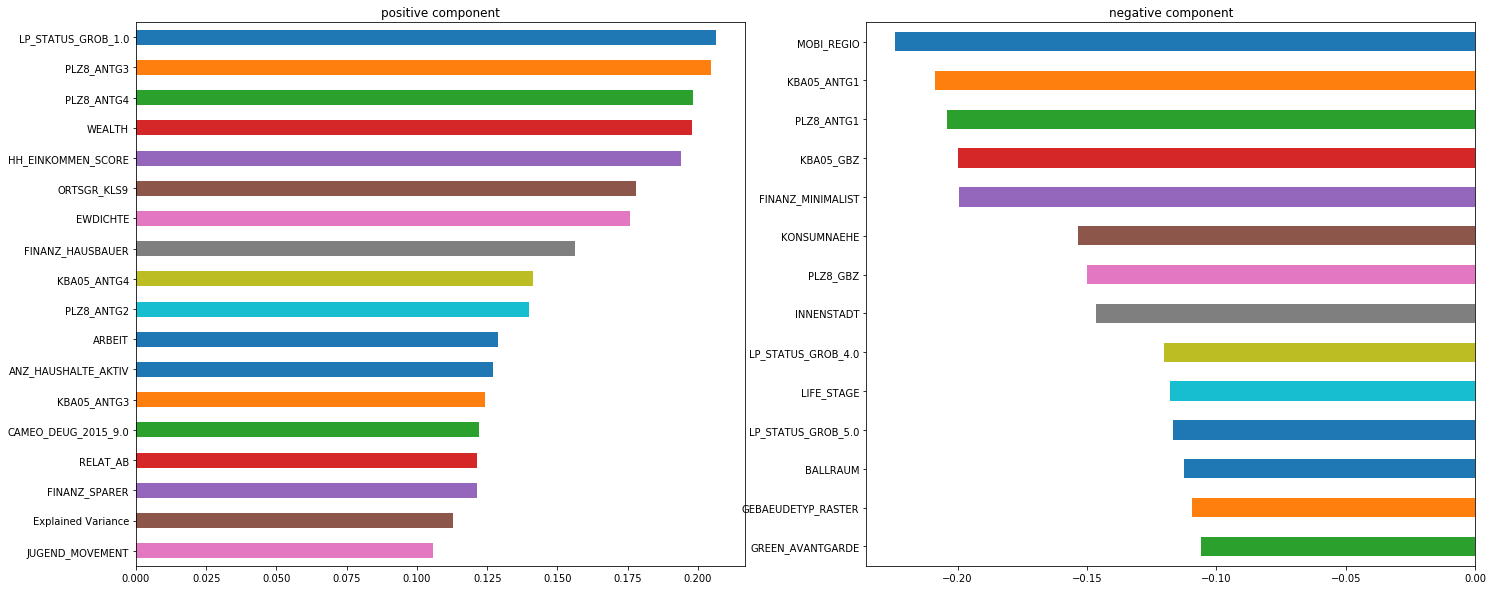

In [89]:
# check the first dimension
select_component(pca_result, pca, 'Dimension 1')

//good article about positive and negative loading https://www.researchgate.net/post/What_does_negative_factor_loading_imply_in_PCA
> I will look at the Top 5 features for both positive and negative components.

### Component1

Positive
- LP_STATUS_GROB_1 (low-income earners, binary, 1:low_income)
- PLZ8_ANTG3 & 4 (Number of 6+ family houses in the PLZ8 region, 1: low share, 2 and 3: high share)
- WEALTH (1: wealthy, 5: poorer)
- HH_EINKOMEN_SCORE (1: highest income, 6: very low income)

Negative
- MOBI_REGIO(Movement patterns, 1: very high movement, 6: none)
- KBA05_ANTG1(Number of 1-2 family houses in the microcell, 1: no 1 or 2 family homes, 4: very high share homes)
- PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region, 1: no 1 or 2 family homes, 4: very high share homes)
- KBA05_GBZ(Number of buildings in the microcell, 1: 1-2 buildings, 5: more than 23 buildings)
- FINANZ_MINIMALIST(low financial interest, 1: very high, 5: very low)

>Looking at the first component, it shows that this group is described as low-income earner who live in high density regions. Negative correlation can be seen with features like no movement or higher interest in finance.

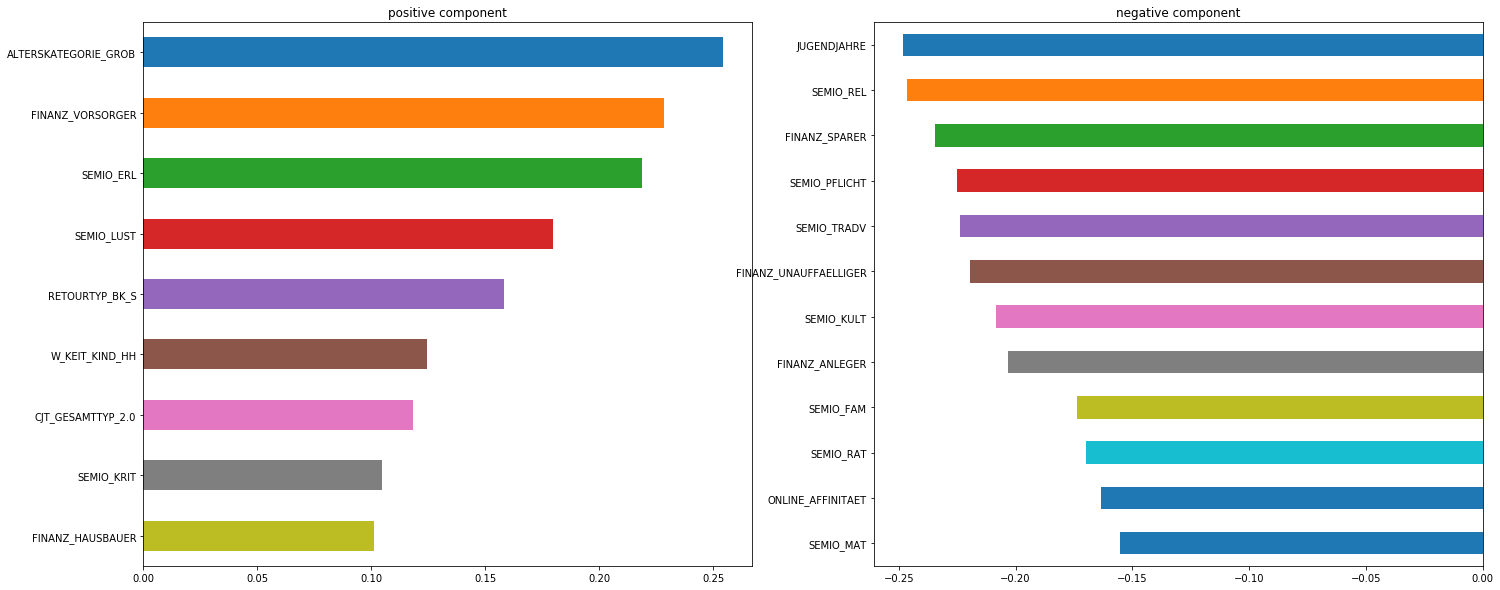

In [90]:
# check the second dimension
select_component(pca_result, pca, 'Dimension 2')

### Component2

Positive

- ALTERSKATEGORIE_GROB(Estimated age based on given name analysis, 1: <30, 4: >60)
- FINANZ_VORSORGER(be prepared, 1: very high, 5: very low)
- SEMIO_ERL(event-oriented, 1: highest affinity, 7: lowest affinity)
- SEMIO_LUST(sensual-minded, 1: highest affinity, 7: lowest affinity)
- RETOURTYP_BK_S(1: influenceable Crazy-Shopper, 5: determined Minimal-Returner)

negative

- JUGENDJAHRE(person's youth, 40th to 90th)
- SEMIO_REL(religious,  1: very high, 5: very low)
- FINANZ_SPARER(money-saver, 1: very high, 5: very low)
- SEMIO_PFLICHT(Accepting of one's legal or moral obligations, 1: very high, 5: very low)
- FINANZ_UNAUFFAELLIGER(inconspicuous, 1: very high, 5: very low)

> This component describes a group of elderly people who are religious and dutiful, and prefer to save money rather than investing it.

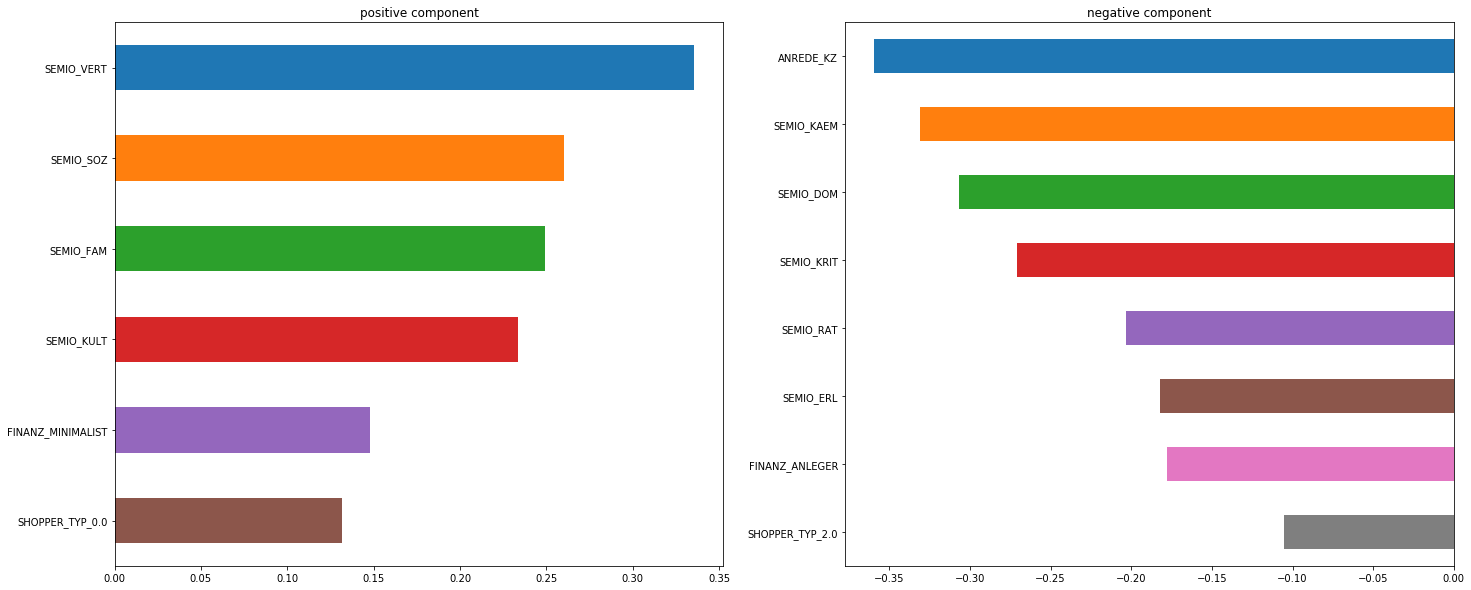

In [91]:
# check the third dimension
select_component(pca_result, pca, 'Dimension 3')

### Component3

Positive

- SEMIO_VERT(dreamful, 1: highest affinity, 7: lowest affinity)
- SEMIO_SOZ(socially-minded, 1: highest affinity, 7: lowest affinit)
- SEMIO_FAM(family-minded, 1: highest affinity, 7: lowest affinit)
- SEMIO_KULT(cultural-minded, 1: highest affinity, 7: lowest affinit)
- FINANZ_MINIMALIST(low financial interest, 1: very high, 5: very low)

Negative

- ANREDE_KZ(Gender, 1: male, 2: female)
- SEMIO_KAEM(combative attitude, 1: highest affinity, 7: lowest affinit)
- SEMIO_DOM(dominant-minded, 1: highest affinity, 7: lowest affinit)
- SEMIO_KRIT(critical-minded, 1: highest affinity, 7: lowest affinit)
- SEMIO_RAT(rational, 1: highest affinity, 7: lowest affinit)

> The third component shows male observations with closed mindset and not dream thinker. Moreover, this group is interested in modey.

### Discussion 2.3: Interpret Principal Components

> The first 3 components have clear characterstics. The first one is described as low-income earner who live in high density regions with low interest in finance and frequent mover. The second one is described a group of elderly people who are religious and dutiful, and prefer to save money rather than investing it. The last component describes male observations with closed mindset. Moreover, this group is interested in money.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [92]:
# over a number of different cluster counts...
kmeans = KMeans(n_clusters = 10)

# run k-means clustering on the data and...
model = kmeans.fit(pca_azdias)

    
    
# compute the average within-cluster distances.
distance = np.abs(model.score(pca_azdias))
distance
    

45065764.56914036

In [93]:
# investigate the change in within-cluster distance across number of clusters.

def k_size(data, n_cluster):
    '''
    This function returns a chart with appropriate cluster numbers
    '''
    distance = []
    for k in range(n_cluster):
        kmean = KMeans(n_clusters = k + 1)
        model = kmean.fit(data)
        scores = np.abs(model.score(data))
        distance.append(scores)
        
        # show the chart
        plt.plot(k + 1 , scores, linestyle='-', marker = 'o', color = 'b')

        plt.title('elbow method')
        plt.xlabel('K')
        plt.ylabel('mean distance')

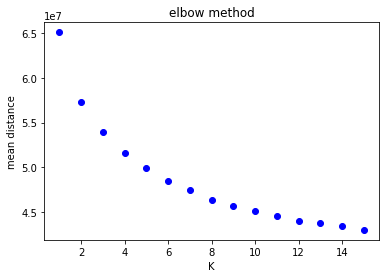

In [94]:
# show chart
k_size(pca_azdias, 15)

> Looking at the chart above, after around 8 to 10 clusters the declinment of mean distance starts to slow down. Therefore, I will set the K to 10.

In [95]:
# re-fit the k-means model with the selected number of clusters and obtain
kmeans = KMeans(n_clusters = 10)
modelk10 = kmeans.fit(pca_azdias)

In [96]:
# cluster predictions for the general population demographics data.
label = modelk10.predict(pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

>To find out the suitable cluster number, I used the elbow method to see the average mean distance between the centroids and their points. It shows that around 8 clusters the declinment of mean distance starts to slow down. However, it can be seen that the distance still goes down when I create more clusters. Therefore, I decided to set the cluster number to 10. This means that I created 10 groups in which the member share similar characterstics.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [97]:
# load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.shape

(191652, 85)

In [98]:
# apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# copy data
copy_customers = customers.copy()
clean_customer = clean_data(copy_customers)
clean_customer.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(139578, 115)

> As the shape is different from the demographic dataset (number of features are 116), I will add one extra column to the customer data.

In [99]:
# take the column name from the list
add_col = miss_col[0]
# add additional column to resize the shape
clean_customer[add_col] = 0

In [100]:
# apply feature scaling to the customer data.
scaler = StandardScaler()
scaler = scaler.fit(clean_customer[clean_customer.columns])
clean_customer[clean_customer.columns] = scaler.transform(clean_customer[clean_customer.columns])
clean_customer.shape

(139578, 116)

In [102]:
# apply pca
pca_customer = pca.transform(clean_customer)
# apply k-means
label_customers = modelk10.predict(pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [103]:
# compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_df = pd.DataFrame(label, columns = ['pred'])
customer_df = pd.DataFrame(label_customers, columns = ['pred'])

In [104]:
# calculate propotion of each labels
general_propotion = (general_df.pred.value_counts() / general_df.shape[0]*100).sort_values()
customer_propotion = customer_df.pred.value_counts() / customer_df.shape[0] *100

In [105]:
# create data frames
general_prop_df = pd.DataFrame(general_propotion).sort_index()
cust_prop_df = pd.DataFrame(customer_propotion).sort_index()
general_prop_df['src'] = 'general'
cust_prop_df['src'] = 'customer'
general_prop_df.reset_index(inplace = True)
cust_prop_df.reset_index(inplace = True)

In [106]:
# concatinate 2 data frames and rename the index as a label
pred_df = pd.concat([general_prop_df, cust_prop_df]).reset_index(drop = True)
pred_df.rename(columns = {'index':'label'}, inplace = True)

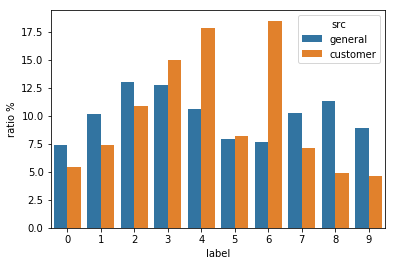

In [107]:
# plot
sns.barplot(data = pred_df, x = 'label', y = 'pred', hue = 'src')
plt.ylabel('ratio %');

> Whilst the cluster 4 and 6 overrepresent in the customer dataset compared to the general population, the cluster 8 and 9 are underrepresented in the customer dataset compared to the general population.

In [108]:
# calculate how many observations with more than 10 missing value
missing_general = miss_obs.shape[0]/clean_azdias.shape[0]*100
missing_cust = customers.shape[0] - clean_customer.shape[0]
missing_cust = missing_cust / customers.shape[0]*100

In [109]:
# create a data frame
missing_df = pd.DataFrame({"ratio": [missing_general, missing_cust], "src": ['general', 'customer']})

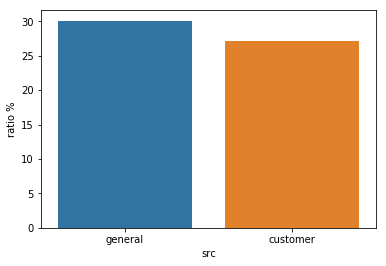

In [110]:
# plot how many % of observations had more than 10 missing value
sns.barplot(data = missing_df, x ='src', y = 'ratio')
plt.ylabel('ratio %');

> In both general demographic data and customer data, there are around 30% of observations with more than 10 missing values. 

In [118]:
# what kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://stackoverflow.com/questions/49885007/how-to-use-scikit-learn-inverse-transform-with-new-values

# get the center of the overrepresented culusters.
# 1st get the k-means center, 2 inverse pca, 3. inverse scaler

center_4 = scaler.inverse_transform(pca.inverse_transform(modelk10.cluster_centers_[4]))
center_6 = scaler.inverse_transform(pca.inverse_transform(modelk10.cluster_centers_[6]))

# create dictionary
cluster_4 = pd.DataFrame(center_4, index = clean_customer.columns, columns = ['centroid_loc'])
cluster_6 = pd.DataFrame(center_6, index = clean_customer.columns, columns = ['centroid_loc'])


# get the center of the underrepresented culusters.
# 1st get the k-means center, 2 inverse pca, 3. inverse scaler
center_8 = scaler.inverse_transform(pca.inverse_transform(modelk10.cluster_centers_[8]))
center_9 = scaler.inverse_transform(pca.inverse_transform(modelk10.cluster_centers_[9]))

# create dictionary
cluster_8 = pd.DataFrame(center_8, index = clean_customer.columns, columns = ['centroid_loc'])
cluster_9 = pd.DataFrame(center_9, index = clean_customer.columns, columns = ['centroid_loc'])

# merge all
df = pd.concat([cluster_4, cluster_6, cluster_8, cluster_9], axis = 1, join_axes=[cluster_4.index])
# set columns name
df.columns = ['cluster_4_over', 'cluster_6_over', 'cluster_8_under', 'cluster_9_under']

In [117]:
# interpret
df

,cluster_4_over,cluster_6_over,cluster_8_under,cluster_9_under
ALTERSKATEGORIE_GROB,3.849575,3.818976,2.737220,2.874354
ANREDE_KZ,0.933088,0.895276,1.780909,0.816463
FINANZ_MINIMALIST,5.377542,5.563528,2.917709,3.458447
FINANZ_SPARER,0.863237,0.844882,2.290170,2.306777
FINANZ_VORSORGER,5.039528,5.021400,3.827106,3.790494
FINANZ_ANLEGER,1.152437,0.687955,2.487433,2.040734
FINANZ_UNAUFFAELLIGER,1.297600,1.554016,2.551274,2.583166
FINANZ_HAUSBAUER,1.783207,1.553812,3.662121,3.109827
GREEN_AVANTGARDE,0.233381,1.436326,0.267337,0.364677
HEALTH_TYP,2.088654,1.820092,1.995212,2.129171


> The overrepresented culusters share following charcteristics:
- Age: between 46 to 60+ (ALTERSKATEGORIE_GROB)
- Interest in money: high (FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_ANLEGER)
- Rationality: high (SEMIO_RAT)
- Income: high (HH_EINKOMMEN_SCORE)
- Movement frequency: low (MOBI_REGIO)
- Wealth: high (WEALTH)

> On the other hands, underpresented culsters share following characteristics:
- Age: younger than the overpresented group in average (ALTERSKATEGORIE_GROB)
- Rationality: low (SEMIO_RAT)
- Income: low (HH_EINKOMMEN_SCORE)
- Number of households:chigh (ANZ_HAUSHALTE_AKTIV)
- Movement frequency: high (MOBI_REGIO)
- Wealth: low (WEALTH)

### Discussion 3.3: Compare Customer Data to Demographics Data

> To identify what kind of people tend to use services from a mail-order sales company in Germany, I summarized some overrepresented characterstics in the customer data. Such segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns.

> People from overrepresented segments are aged over 46 years and are highly interested in money. Moreover, they have higher income and tend to stay at the same place. It may be that they own their houses.

> Therefore, I should recommend the company to focus on people who share similar characteristics for their marketing campaigns.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.